In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 115.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb  # For ECG data parsing
import os

In [12]:
def encode_repetition(bits):
    """Repeats every bit 3 times.
    [1, 0] -> [1, 1, 1, 0, 0, 0]"""


    return np.repeat(bits, 3)


def quantize_LLR(L, bits_precision, Lmax):
    """
    Quantizes LLR values to simulate limited hardware precision .
    """
    # Clip to range
    L_clipped = np.clip(L, -Lmax, Lmax)
    # Define steps
    levels = 2**bits_precision
    step_size = 2 * Lmax / (levels - 1)
    # Quantize
    return np.round(L_clipped / step_size) * step_size


In [13]:



def decode_hard_repetition(rx_signal):
    """
    Hard Decision Decoder for Repetition(3,1).
    Logic: Threshold -> Majority Vote.
    """
    # rx > 0 -> 0 (mapped to +1), rx < 0 -> 1 (mapped to -1)
    rx_bits_raw = np.where(rx_signal > 0, 0, 1)

    # Majority Vote (reshape to groups of 3)
    rx_chunks = rx_bits_raw.reshape(-1, 3)

    # If sum >= 2 (two or three 1s), decode as 1.
    decoded_bits = np.where(np.sum(rx_chunks, axis=1) >= 2, 1, 0)

    return decoded_bits

def decode_soft_repetition(rx_signal, sigma, quantization_bits=0, Lmax=8):
    """
    Soft Decision Decoder for Repetition(3,1).
    Logic: Calculate LLRs -> (Optional Quantize) -> Sum -> Threshold.
    """

    # LLR = 2 * y / sigma^2
    LLR = (2 * rx_signal) / (sigma**2)

    #  Optional: Quantize LLRs (Stretch Goal)
    if quantization_bits > 0:
        LLR = quantize_LLR(LLR, quantization_bits, Lmax)

    # Combine Soft Information (Sum LLRs)
    LLR_chunks = LLR.reshape(-1, 3)
    soft_sums = np.sum(LLR_chunks, axis=1)

    # Final Decision
    # Sum > 0 -> likely 0. Sum < 0 -> likely 1.
    decoded_bits = np.where(soft_sums > 0, 0, 1)

    return decoded_bits

In [14]:

def run_simulation_repetition(bits, EbN0_dB, quantization_bits=0):
    """
    Simulates transmission and returns decoded bits for Hard and Soft decisions.
    """
    # 1. Encode
    tx_bits = encode_repetition(bits)

    # 2. Modulate (0 -> +1, 1 -> -1)
    tx_signal = np.where(tx_bits == 0, 1.0, -1.0)

    # 3. Add Noise
    R = 1/3 # Rate
    EbN0_lin = 10**(EbN0_dB / 10.0)
    sigma = np.sqrt(1 / (2 * R * EbN0_lin))

    rng = np.random.default_rng(2025)
    noise = rng.normal(0, sigma, len(tx_signal))
    rx_signal = tx_signal + noise

    # 4. Decode
    dec_hard = decode_hard_repetition(rx_signal)
    dec_soft = decode_soft_repetition(rx_signal, sigma, quantization_bits)

    return dec_hard, dec_soft


In [17]:
def solve_snr_for_ber(snr_values, ber_values, target_ber):
    """
    Finds the exact SNR where the curve crosses the target_ber
    using linear interpolation in the log-BER domain.
    """
    # Convert BER to log scale for linearity
    log_ber = np.log10(ber_values)
    log_target = np.log10(target_ber)

    # Find the interval where the crossing happens
    for i in range(len(log_ber) - 1):
        if log_ber[i] >= log_target >= log_ber[i+1]:
            # Linear Interpolation formula: x = x1 + (y - y1) * (x2 - x1) / (y2 - y1)
            y1, y2 = log_ber[i], log_ber[i+1]
            x1, x2 = snr_values[i], snr_values[i+1]

            interpolated_snr = x1 + (log_target - y1) * (x2 - x1) / (y2 - y1)
            return interpolated_snr
    return None

Eb/N0    | Hard BER   | Soft (Float) | Soft (3bit)  | Soft (4bit) 
-----------------------------------------------------------------
0        | 0.11114     | 0.07905       | 0.10614       | 0.08490
1        | 0.08491     | 0.05603       | 0.07536       | 0.06015
2        | 0.06241     | 0.03733       | 0.05004       | 0.04009
3        | 0.04276     | 0.02292       | 0.03047       | 0.02443
4        | 0.02707     | 0.01258       | 0.01671       | 0.01349
5        | 0.01535     | 0.00592       | 0.00794       | 0.00631
6        | 0.00770     | 0.00242       | 0.00314       | 0.00254
7        | 0.00329     | 0.00077       | 0.00098       | 0.00081
8        | 0.00121     | 0.00018       | 0.00024       | 0.00020
9        | 0.00035     | 0.00003       | 0.00005       | 0.00004
10       | 0.00010     | 0.00001       | 0.00001       | 0.00001
11       | 0.00002     | 0.00000       | 0.00000       | 0.00000

--- GAIN CALCULATION ---
Target BER: 0.001
Hard Decision requires: 8.15 dB
Soft Decisi

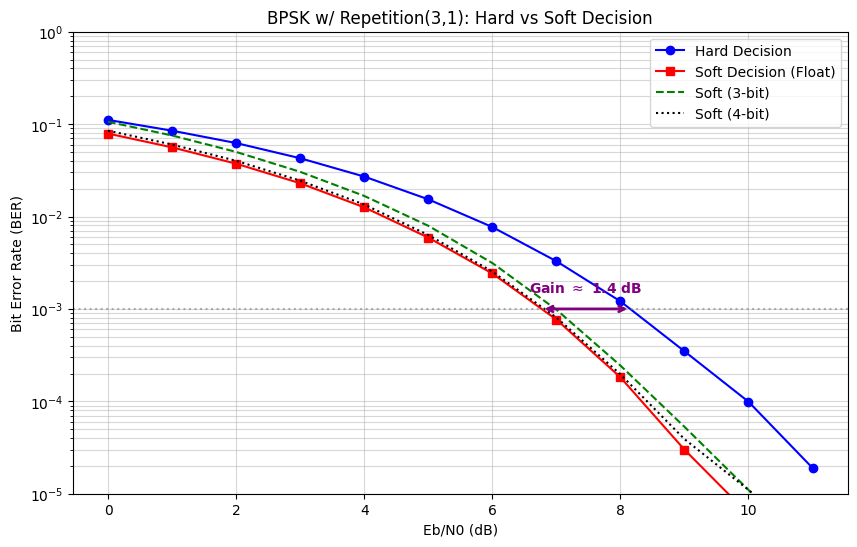

In [20]:
n_bits = 1_000_000  # High bit count for smooth curves
EbN0_range = np.arange(0, 12, 1)

ber_hard, ber_soft_float = [], []
ber_soft_3bit, ber_soft_4bit = [], []

print(f"{'Eb/N0':<8} | {'Hard BER':<10} | {'Soft (Float)':<12} | {'Soft (3bit)':<12} | {'Soft (4bit)':<12}")
print("-" * 65)

rng = np.random.default_rng(2025)

for snr in EbN0_range:
    tx_bits = rng.integers(0, 2, n_bits)

    # Run decoders
    h_out, s_float = run_simulation_repetition(tx_bits, snr, quantization_bits=0)
    _, s_3bit = run_simulation_repetition(tx_bits, snr, quantization_bits=3)
    _, s_4bit = run_simulation_repetition(tx_bits, snr, quantization_bits=4)

    # Calculate Errors
    err_h = np.mean(tx_bits != h_out)
    err_f = np.mean(tx_bits != s_float)
    err_3 = np.mean(tx_bits != s_3bit)
    err_4 = np.mean(tx_bits != s_4bit)

    ber_hard.append(err_h)
    ber_soft_float.append(err_f)
    ber_soft_3bit.append(err_3)
    ber_soft_4bit.append(err_4)

    print(f"{snr:<8} | {err_h:.5f}     | {err_f:.5f}       | {err_3:.5f}       | {err_4:.5f}")

# --- Calculate Soft Decision Gain ---
target_ber = 1e-3
snr_hard_req = solve_snr_for_ber(EbN0_range, ber_hard, target_ber)
snr_soft_req = solve_snr_for_ber(EbN0_range, ber_soft_float, target_ber)

print("\n--- GAIN CALCULATION ---")
if snr_hard_req and snr_soft_req:
    gain = snr_hard_req - snr_soft_req
    print(f"Target BER: {target_ber}")
    print(f"Hard Decision requires: {snr_hard_req:.2f} dB")
    print(f"Soft Decision requires: {snr_soft_req:.2f} dB")
    print(f"Soft Decision Gain:     {gain:.2f} dB")
else:
    print("Gain could not be calculated (Target BER not reached in range)")

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.semilogy(EbN0_range, ber_hard, 'b-o', label='Hard Decision')
plt.semilogy(EbN0_range, ber_soft_float, 'r-s', label='Soft Decision (Float)')
plt.semilogy(EbN0_range, ber_soft_3bit, 'g--', label='Soft (3-bit)')
plt.semilogy(EbN0_range, ber_soft_4bit, 'k:', label='Soft (4-bit)')

# Annotate Gain on Plot
if snr_hard_req and snr_soft_req:
    plt.axhline(y=target_ber, color='gray', linestyle=':', alpha=0.6)
    plt.annotate('', xy=(snr_hard_req, target_ber), xytext=(snr_soft_req, target_ber),
                 arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
    plt.text((snr_hard_req + snr_soft_req)/2, target_ber * 1.5,
             f"Gain $\\approx$ {gain:.1f} dB", color='purple', ha='center', fontweight='bold')

plt.title('BPSK w/ Repetition(3,1): Hard vs Soft Decision')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which="both", alpha=0.5)
plt.legend()
plt.ylim(1e-5, 1)
plt.show()

In [24]:
# ==================================
# Example Medical ECG Transmission)
# ==================================


def get_local_ecg_bits(record_name='105', seconds=10):
    """Reads local .dat/.hea files and converts to bits."""

    print(f"Loading {seconds}s of ECG from local file: {record_name}.dat ...")
    record = wfdb.rdrecord(record_name, sampto=360*seconds)
    signal = record.p_signal[:, 0]

    # Normalize float signal to 0-255 int (8-bit)
    min_v, max_v = np.min(signal), np.max(signal)
    norm_sig = (signal - min_v) / (max_v - min_v)
    int_sig = np.round(norm_sig * 255).astype(int)

    # Convert ints to bits
    bit_list = []
    for val in int_sig:
        b_str = format(val, '08b')
        bit_list.extend([int(c) for c in b_str])
    return np.array(bit_list), min_v, max_v

In [23]:
def bits_to_signal(bits, min_val, max_val):
    """Reconstructs float signal from bits."""
    # Ensure full bytes
    valid_len = (len(bits) // 8) * 8
    bits = bits[:valid_len]
    bytes_list = bits.reshape(-1, 8)

    # Binary to Int
    powers = 2**np.arange(7, -1, -1)
    int_vals = np.sum(bytes_list * powers, axis=1)

    # Int to Float
    return (int_vals / 255.0) * (max_val - min_val) + min_val

Loading 5s of ECG from local file: 105.dat ...
Transmitting Medical Data at Low SNR (3.0 dB)...

Results for ECG Transmission:
Hard Decision BER: 0.0434
Soft Decision BER: 0.0243
Improvement Factor: 1.8x fewer errors


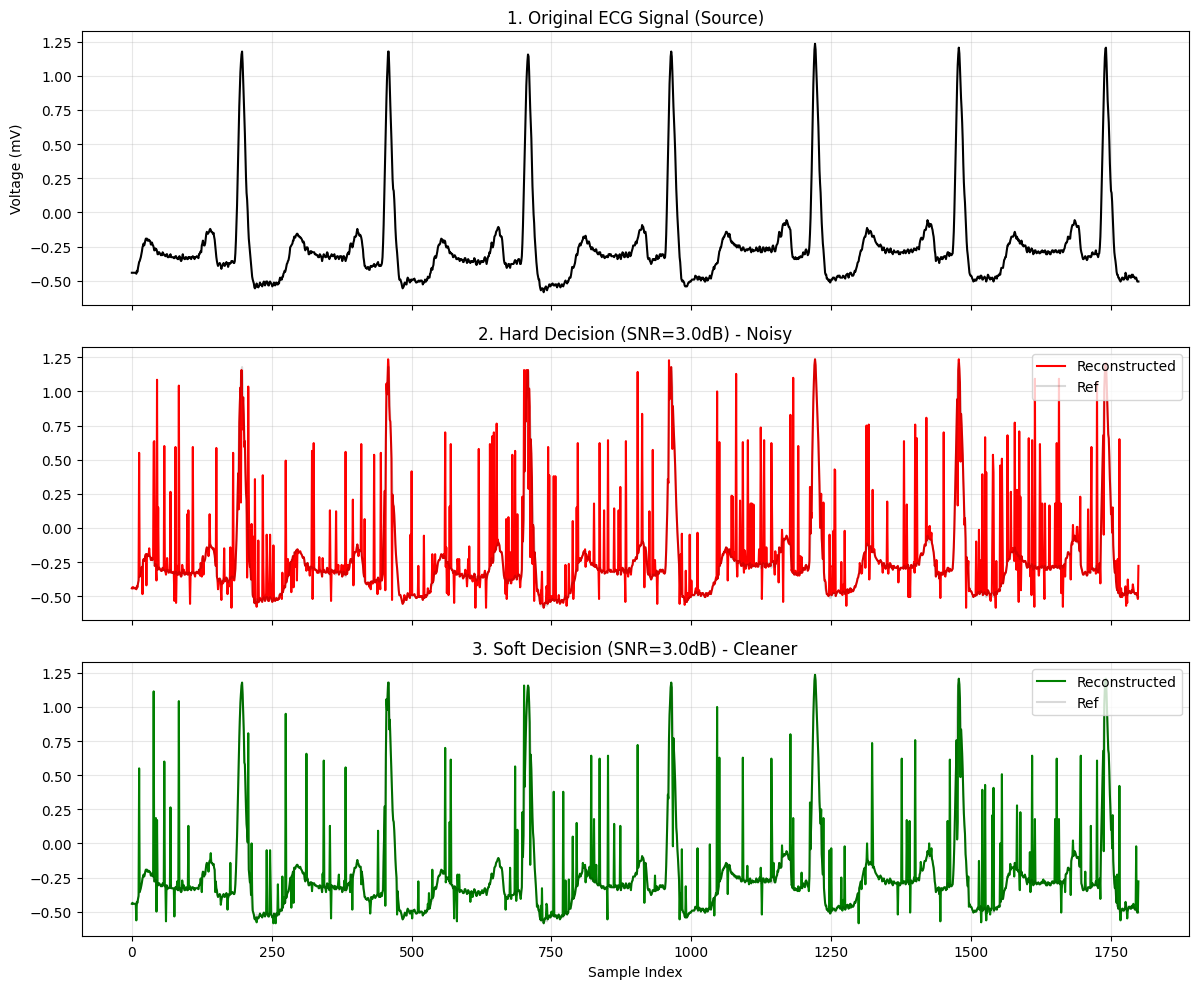

In [28]:
# Define the record name we are looking for
record_name = '105'

# Check if the specific files exist in the current directory
if os.path.exists(record_name + '.dat') and os.path.exists(record_name + '.hea'):

    # Load ECG Data

    ecg_bits, smin, smax = get_local_ecg_bits(record_name=record_name, seconds=5)

    # Transmit a SNR (to highlight performance difference)
    test_snr = 3.0
    print(f"Transmitting Medical Data at Low SNR ({test_snr} dB)...")

    # Use the SAME decoder
    h_bits, s_bits = run_simulation_repetition(ecg_bits, test_snr)

    # Reconstruct Signals
    sig_orig = bits_to_signal(ecg_bits, smin, smax)
    sig_hard = bits_to_signal(h_bits, smin, smax)
    sig_soft = bits_to_signal(s_bits, smin, smax)

    # Calculate BER for this transmission
    err_h = np.mean(ecg_bits != h_bits)
    err_s = np.mean(ecg_bits != s_bits)

    print(f"\nResults for ECG Transmission:")
    print(f"Hard Decision BER: {err_h:.4f}")
    print(f"Soft Decision BER: {err_s:.4f}")

    if err_s > 0:
        print(f"Improvement Factor: {err_h/err_s:.1f}x fewer errors")

    # Plot Comparison

    fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    ax[0].plot(sig_orig, 'k')
    ax[0].set_title("1. Original ECG Signal (Source)")
    ax[0].grid(alpha=0.3)
    ax[0].set_ylabel("Voltage (mV)")

    ax[1].plot(sig_hard, 'r', label='Reconstructed')
    ax[1].plot(sig_orig, 'k', alpha=0.15, label='Ref')
    ax[1].set_title(f"2. Hard Decision (SNR={test_snr}dB) - Noisy")
    ax[1].legend(loc='upper right')
    ax[1].grid(alpha=0.3)

    ax[2].plot(sig_soft, 'g', label='Reconstructed')
    ax[2].plot(sig_orig, 'k', alpha=0.15, label='Ref')
    ax[2].set_title(f"3. Soft Decision (SNR={test_snr}dB) - Cleaner")
    ax[2].legend(loc='upper right')
    ax[2].grid(alpha=0.3)
    ax[2].set_xlabel("Sample Index")

    plt.tight_layout()
    plt.show()

else:

    print(f"\n[!] Error: '{record_name}.dat' or '{record_name}.hea' not found.")
    print("    Please ensure you uploaded the files to the notebook folder.")